# Classification Model of Canadian Cheeses
## Author: Gloria Mo

## Introduction

The goal of this project is to develop a predictve model that distinguishes between "higher fat" and "lower fat" Canadian cheeses based on various features such as moisture content, manufacturing location, milk type and more. 

The question I will be answering is: ***Can we accurately predict the "Fat Level" (lower fat/higher fat) of Canadian cheeses based on their characteristics?***

I am interested to see if the features "Moisuture Percentage", "ManufacturerProvCode", "ManufacturingTypeEn", "MoisturePercent", "Organic", "CategoryTypeEn", "MilkTypeEn", and "MilkTreatmentTypeEn", can be used to accurately predict the fat level of different types of cheeses. This project will be applicable to the food industry and for consumers. Correctly classifying the fatness level of cheeses is important for consumers as individuals have different dietary preferences and restrictions. As well, it is important for nutritional labeling and marketing. In this project, I will use a classification model to distinguish between two classes of cheese: "lower fat" and "higher fat". The expected outcome is a classification model that can categorize cheeses into fat levels with high accuracy. 

### Dataset Description
The dataset I will be focusing on in this project is obtained from Government of Canada's Open Government Portal. The dataset includes different types of Canadian cheeses.

The dataset I used in this analysis is:
* **cheese_data.csv**

## Exploratory Data Analysis

First we will import in all the required libraries for our analysis.

In [1]:
#Import required libraries
import altair as alt
import numpy as np
import pandas as pd
import string
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

from scipy.stats import lognorm, loguniform, randint

In [2]:
# Import required files
cheese_df = pd.read_csv('data/cheese_data.csv')
cheese_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


I will first perform some initial data cleaning to our dataframe so that only the features relevant to the project are included. I am only interested in the features "ManufacturerProvCode", "ManufacturingTypeEn", "MoisturePercent", "Organic", "CategoryTypeEn", "MilkTypeEn", "MilkTreatmentTypeEn", and "FatLevel" will be target feature so I will drop the other features. The features dropped either do not contribute to the prediction (e.g "CheeseId") or are dropped for convenience (e.g "FlavourEn", "CharacteristicsEn", "RindTypeEn", "CheeseName").

In [3]:
# Drop columns
cheese_df = cheese_df.drop(columns=['CheeseId', 'FlavourEn', 'CharacteristicsEn', 'RindTypeEn', 'CheeseName'])
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,lower fat


In [4]:
# Splitting the data
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=['FatLevel']), train_df['FatLevel']
X_test, y_test = test_df.drop(columns=['FatLevel']), test_df['FatLevel']
X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized


First, let's visualize some of the data to better understand what we are working with. 

In [22]:
fatlevel_plot = alt.Chart(cheese_df).mark_bar().encode(
    alt.X('FatLevel', title="Fat Level"),
    alt.Y('count()', title="Number of Cheeses", sort="x")).properties(title="Figure 1: Number of Canadian Cheeses with High Fat vs Low Fat")
fatlevel_plot

alt.Chart(...)

Figure 1. visualizes the number of higher fat vs lower fat Canadian cheeses in the dataset. This shows us that there are a higher number of lower fat Canadian cheeses, approximately 690 compared to 350 higher fat cheese options. This allows us to have an overview of the variety of fatness level of the Canadian cheeses that we are working with in our dataset.

In [23]:
moisure_plot = alt.Chart(cheese_df).mark_circle().encode(
    alt.X('MoisturePercent:Q', title="Moisture Percentage (%)"),
    alt.Y('FatLevel:N', title="Fat Level", sort="x"),
    alt.Color('FatLevel', title='Fat Level')).properties(title="Figure 2: Fat Level vs Moisture Percentage of Canadian Cheeses")
moisure_plot

alt.Chart(...)

Figure 2. showcases Moisture Percentage vs Fat Level of Canadian cheeses. We can see that the blue circles on top are the higher fat cheeses and the orange circles on the bottom are the lower fat cheeses. We can infer a relationship between moisture percentage of cheese vs fat level. It seems that, on average, lower fat Canadian cheeses seem to have a higher moisture percentage whereas higher fat Canadian cheeses have a lower moisture percentage. 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 482 to 1041
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       821 non-null    float64
 3   Organic               833 non-null    int64  
 4   CategoryTypeEn        813 non-null    object 
 5   MilkTypeEn            832 non-null    object 
 6   MilkTreatmentTypeEn   781 non-null    object 
 7   FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 58.6+ KB


The dataset includes information regarding characteristics of Canadian cheeses such as the province code of the manufacturer, the type of manufacturing process, moisture content (%), whether the cheese is organic, its category type, the type of milk used, the treatment applied to the milk, and the fat level. It has 833 entries and 8 features after data cleaning so it is a moderately sized dataset with a wide range of attributes for each cheese value.

There seems to be null values in the features "MoisturePercent", "CategoryTypeEn", "MilkTypeEn", and "MilkTreatmentTypeEn" so preprocessing will be used to address the missing values. We can also see that most features have Dtype "object" except for "MoisturePercent" being float64 and "Organic" being int64. I will be transforming the numeric columns with imputation and scaling and imputation and one-hot encoding for the categorical columns.

Here is the distribution of target values (Fat Level) in the train split:

In [8]:
class_dist = y_train.value_counts('Class')
class_dist

lower fat     0.657863
higher fat    0.342137
Name: FatLevel, dtype: float64

 It seems the distribution is slightly imbalanced with around 66% of the class being "lower fat" values. This minor imbalance in data could be due to many different factors such as the cost factors or resources available for manufacturering different kinds of Canadian cheeses. This distribution was also visualized in our "fatlevel_plot" which compared the number of higher fat vs lower fat Canadian cheeses. Since there is a slight imbalance, I will change the training procedure by setting the parameter class_weight="balanced" in our classifier to combat this.

The metrics I will use to evaluate the success of the project will be 
**F1-score** and **precision**. Since this is a binary classification problem, while still important, it is not a major requirement to prioritize reducing false negatives or false positives over one another. However, the success of the project should be measured by minimizing the overall number of mislabelled classifications. 

* True Positive: Predicting "lower fat" when the actual class is "lower fat"
* True Negative: Predicting "higher fat" when the actual class is "higher fat"
* False Positive: Predicting "lower fat" when the actual class is "higher fat"
* False Negative: Predicting "higher fat" when the actual class is "lower fat" 

As there is a minor imbalance between the two classes, F1-score will allow us to consider both the false positives and false negatives and give us good insight on the model's precision and recall as it will give us a balance between minimizing both false positives and false negatives. 

Precision will allow us to measure how many of the cheeses to be predicted to have 'higher fat' content actually have a 'higher fat' content. This will help us minimize false positives such as incorrectly labeling 'lower fat' cheeses as 'higher fat' cheeses and vice versa. This is will be important in product labelling as consumers have different dietary restrictions and preferences.

## Methods and Results

In [9]:
# Create a baseline model

dummy = DummyClassifier(strategy='most_frequent')

dummy_scores = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))
dummy_scores

,fit_time,score_time,test_score,train_score
0,0.004848,0.002094,0.658683,0.657658
1,0.002563,0.000740,0.658683,0.657658
2,0.002181,0.000888,0.658683,0.657658
3,0.002088,0.001117,0.656627,0.658171
4,0.036741,0.000834,0.656627,0.658171


In [10]:
dummy_scores_mean = dummy_scores.mean()
dummy_scores_mean

fit_time       0.009684
score_time     0.001135
test_score     0.657860
train_score    0.657863
dtype: float64

First I will use a basic linear model with Logistic Regression as a way to compare different classification models.

In [11]:
# Split the numeric and categorical features 

numeric_features = ['MoisturePercent']

binary_features = ['Organic']

categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn', 'CategoryTypeEn']

# Make Pipelines

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

binary_transformer = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(drop='if_binary', dtype=int))

# Column transformer

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        (binary_transformer, binary_features)
)

# Build a main pipeline with a basic linear model

lr_pipe = make_pipeline(preprocessor, LogisticRegression())

lr_pipe.fit(X_train, y_train)

#y_pred = main_pipe.predict(X_test)

# Cross validate

lr_scores = pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, return_train_score=True))

lr_scores

,fit_time,score_time,test_score,train_score
0,0.054870,0.015794,0.784431,0.788288
1,0.064538,0.014400,0.808383,0.801802
2,0.053915,0.014794,0.736527,0.812312
3,0.061827,0.015137,0.789157,0.800600
4,0.057769,0.015261,0.771084,0.802099


In [12]:
lr_scores_mean = lr_scores.mean()
lr_scores_mean

fit_time       0.058584
score_time     0.015077
test_score     0.777916
train_score    0.801020
dtype: float64

There is one obvious numeric feature "Moisture Percent" as it is Dtype float64 as seen when we analyzed the information of the dataset. The feature "Organic" is of Dtype int64, however, we can see it only has the binary values: [0,1] so I consider it as a binary feature. The rest of the columns are considered categorical features as they all have fitting categories. I believe CategoryTypeEn can be considered an Ordinal Feature with the order of ['Soft Cheese', 'Semi-soft Cheese', 'Firm Cheese', 'Hard Cheese'], however, the values "Fresh Cheese" and "Veined Cheeses" do not seem to fall under the Cheese Firmness Level scale as stated here:
https://www.wisconsincheeseman.com/blog/cheese-nation/types-cheese-texture-talk/
Thus, I have decided to consider CategoryTypeEn as a categorical feature instead of ordinal. 

In [13]:
# Test RandomForestClassifier
# class_weight='balanced' is used to help with class imbalances in dataset
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced', random_state=77, n_estimators=10))

rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore...
                   

I have decided to choose Random Forest Classifier (RFC) as the choice of classification model to compare with our baseline dummy classifier and basic linear regression model. I have chosen RFC because the model is appropriate for handling large and complex datasets and it has high accuracy while still minimizing overfitting which will be beneficial for distinguishing between the two fat level classes.

In [14]:
rf_scores = pd.DataFrame(cross_validate(rf_pipe, X_train, y_train, cv=5, return_train_score=True))
rf_scores

,fit_time,score_time,test_score,train_score
0,0.092888,0.016587,0.814371,0.944444
1,0.069522,0.019465,0.790419,0.948949
2,0.063532,0.020454,0.814371,0.944444
3,0.065473,0.019743,0.813253,0.940030
4,0.059845,0.019138,0.777108,0.938531


In [15]:
rf_scores_mean = rf_scores.mean()
rf_scores_mean

fit_time       0.070252
score_time     0.019078
test_score     0.801905
train_score    0.943280
dtype: float64

In [16]:
# Hyperparameter Optimization
# Code is obtained from canvas through the IML course

import scipy
from scipy.stats import randint

param_grid = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20)
}

random_search = RandomizedSearchCV(
    rf_pipe,
    param_grid,
    n_iter=50,
    cv=3,
    verbose=1,
    #scoring="f1",
    random_state=123,
    return_train_score=True
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

In [17]:
optimal_parameters = random_search.best_params_
optimal_score = random_search.best_score_
print(optimal_parameters)
print(optimal_score)

{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 156}
0.8367399942861594


## Discussion

In [18]:
print('Random Forest Classifier mean training score: ' + str(round(rf_scores_mean['train_score'], 2)))
print('Logistic Regressor mean training score: ' + str(round(lr_scores_mean['train_score'], 2)))
print('Dummy Classifier mean training score: ' + str(round(dummy_scores_mean['train_score'], 2)))

Random Forest Classifier mean training score: 0.94
Logistic Regressor mean training score: 0.8
Dummy Classifier mean training score: 0.66


Based on the results, I have compared a baseline dummy model, a linear regressor model, and a random forest classifier model. Our results show that the RFC performs the best with a mean training score of 0.94 while the logistic regressor has the second best performance of a mean score of 0.80 and the dummy classifier is last with a score of 0.66.

The Random Forest Classifier outperforms the other models due to many reasons. Since the random forest model is made up of multiple decision trees, it has the benefit of being less prone to overfitting compared to individual decision trees since the average lowers the overall variance and prediction error. As well, the RFC can handle non-linear relationships while Logistic Regression cannot. Hyperparameter tuning was also used which further improved the optimization of the model performance.

In [19]:
# Evaluate on test set

train_score = random_search.score(X_train, y_train)
test_score = random_search.score(X_test, y_test)
print('Train score: ' + str(round(train_score, 2)))
print('Test score: ' + str(round(test_score, 2)))

Train score: 0.94
Test score: 0.85


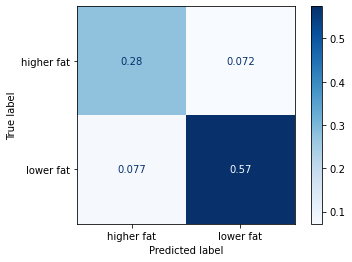

In [20]:
# Plot confusion matrix

cm_plot = plot_confusion_matrix(random_search, X_test, y_test, cmap='Blues', normalize='all')

Our confusion matrix shows us our results:
* True positive: 0.57
* True negative: 0.28
* False positive: 0.072
* False negative: 0.077

Our results show that our model correctly classified a majority of "lower fat" cheeses. This suggests the model is effective at recognizing instances that truly belong to the positive class. The true negative rate shows our model correctly classifies "higher fat" cheeses 28% of the time. The model is less effective at correctly identifying instances of negaive class. The false positive and false negative rate is relatively low at 7.2% and 7.7%, respectively, indicating that the model makes fewer errors in incorrectly classifying instances as "lower fat" when they are actually "higher fat" and vice versa. This means the number of false alarms and missed identifications are relatively low. 

Overall, the model's performance seems to be well as it has a decent true positive rate and low false positive and low false negative rate. However, the true negative rate is quite low and this may lead to incorrect labelling of "higher fat" cheeses. This may not be that big of an issue as labelling cheese as lower fat while it is actually higher fat cheese may be considered a more costly mistake as individuals may avoid higher fat content products.

In [21]:
# Print classification report

best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  higher fat       0.78      0.79      0.79        73
   lower fat       0.89      0.88      0.89       136

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209



Precision
  * In our model, we see that the precision score for predicting "higher fat" cheeses is 78%, thus, out of all cheeses predicted to be "higher fat", 78% is actually "higher fat". We can also see that the precision for predicting "lower fat" cheeses is 89%, thus, out of all cheeses predicted to be "lower fat", 89% is actually "lower fat". Furthermore, the precision weighted average is 85%. 
    
F1-Score
  * The f1 score for predicting "higher fat" and "lower fat" cheeses is 79% and 89%, respectively. 
    
We can see that there are 73 "higher fat" cheeses and 136 "lower fat" cheeses in the test set which may explain why precision and f1-score are higher for predicting "lower fat" cheeses.

Overall, the model performs with relatively high preicison and F1-score for both classes, indicating that performs well in distinguishes between "higher fat" and "lower fat" cheeses. The accuracy score of 85% is relatively high sugggesting the model should perform well in classifying cheeses based on their fat levels with the given features.  

It is possible the quality of the collected data such as missing values or outliers may also affect the model's ability to generalize and perform. We saw at the beginning that there is an slight imbalanced data set where we saw more "lower fat" cheese compared to "higher fat" cheese. The RFC may be biased towards the majority class, "lower fat" which may impact the predictive performance of the minority class, "higher fat".

If I were to further analyze this prediction model, I would try different types of classification models with different levels of complexity that could potentially improve the model's performance. For example, I could try KNeighborsClassifier as well as Support Vector Machines as it is possible similary-based algorithms may yield different results than the tested decision tree model. Furthermore, the design of my model could be further iterated as the relevance of features used by the model can impact the performance. For example, including more features such as "CharacteristicsEn" by using CountVectorizer to transform the column. 

To add on, the complexity of the model can also be reconsidered as feature selection/engineering was not performed in my model. Including feature importance scores would allow me to narrow down which features have the most influence on predictions so that irrelevant features can be excluded from the project. As well, feature engineering could possibily enhance the model's ability to find different patterns in the data. Using these techniques would minimize overfitting and allow the model to address the most important features of the dataset. Further hyperparameter tuning should also be performed so that the most optimal hyperparameters are covered for the selected model and could lead to potentially better results. 

Overall, the current model shows potential and yields a relatively high F1-score and precision score, there are many areas where further refinement could lead to improved performance.

## References

* Data Source
    * The Canadian Cheese dataset is obtained from the Government of Canada's Open Government Portal
    
* Data Analysis
    * Reference to code made throughout this project and is obtained from canvas through the IML course
    
* Model comparison
    * Information about advantages/disadvantages of Random Forest Classifiers were obtained from:
        * https://www.ibm.com/topics/random-forest
        * https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
* Cheese information
    * Information about cheese firmness level:
        * https://www.wisconsincheeseman.com/blog/cheese-nation/types-cheese-texture-talk/